## DFO Nutrient Comparison

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import gsw
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm
import cmocean as cmo
import scipy.interpolate as sinterp
import pickle
import cmocean
from collections import OrderedDict

mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)
mpl.rc('legend', fontsize=8)
mpl.rc('axes', titlesize=8)
mpl.rc('axes', labelsize=8)
mpl.rc('figure', titlesize=8)
mpl.rc('font', size=8)
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble =r'''
 \usepackage{txfonts}
 \usepackage{lmodern}
 ''')
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

%matplotlib inline

In [2]:
PATH= '/results2/SalishSea/nowcast-green.201905/'
start_date = dt.datetime(2013,1,1)
end_date = dt.datetime(2018,1,1)
flen=1
namfmt='nowcast'
#varmap={'N':'nitrate','Si':'silicon','Ammonium':'ammonium'}
filemap={'nitrate':'ptrc_T','silicon':'ptrc_T','ammonium':'ptrc_T','diatoms':'ptrc_T','ciliates':'ptrc_T','flagellates':'ptrc_T','vosaline':'grid_T','votemper':'grid_T'}
#gridmap={'nitrate':'tmask','silicon':'tmask','ammonium':'tmask'}
fdict={'ptrc_T':1,'grid_T':1}
saveloc='/data/eolson/MEOPAR/SS36runs/calcFiles/evalMatches/'
fname=f'data_DFOBot_HC1905_{start_date.strftime("%Y%m%d")}_{end_date.strftime("%Y%m%d")}.pkl'
print(fname)
rematch=False
if rematch==True:
    df1=et.loadDFO()
    df1.head()
    data=et.matchData(df1,filemap, fdict, start_date, end_date, namfmt, PATH, flen)
    pickle.dump(data,open(os.path.join(saveloc,fname),'wb'))
else:
    data=pickle.load(open(os.path.join(saveloc,fname),'rb'))

data_DFOBot_HC1905_20130101_20180101.pkl


In [3]:
def rotmap(lon,lat,lon0,lat0,phi):
    # rotate around point (pick one near center of domain)
    # phi in degrees
    # first scale lats to match and center around lat0,lon0:
    lon1=(lon-lon0)*np.cos(lat0*np.pi/180)
    lat1=lat-lat0
    # now rotate:
    lon2=lon1*np.cos(phi*np.pi/180)-lat1*np.sin(phi*np.pi/180)
    lat2=lon1*np.sin(phi*np.pi/180)+lat1*np.cos(phi*np.pi/180)
    return lon2,lat2

In [4]:
cm1=cmocean.cm.thermal
#plt.get_cmap('PuBuGn')
#cm1=cmo.cm.matter
theta=-30
lon0=-123.9
lat0=49.3
with nc.Dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/bathymetry_201702.nc') as bathy:
    bathylon=np.copy(bathy.variables['nav_lon'][:,:])
    bathylat=np.copy(bathy.variables['nav_lat'][:,:])
    bathyZ=np.copy(bathy.variables['Bathymetry'][:,:])
blon,blat=rotmap(bathylon,bathylat,lon0,lat0,theta)

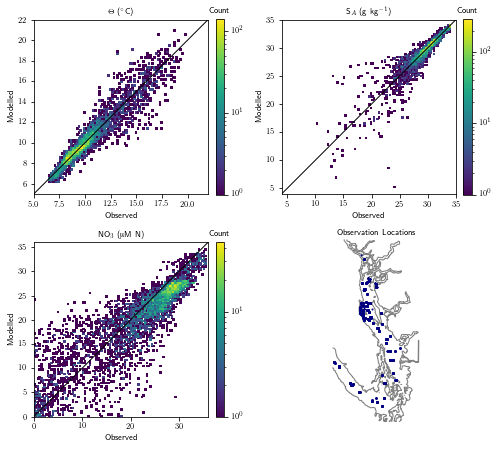

In [54]:
fig = plt.figure(figsize = (7,6.3))
gsv = gridspec.GridSpec(2,2,left=.08,right=.95,bottom=.05,top=.95,
                        hspace=.2,wspace=.3)
#gs1=gridspec.GridSpecFromSubplotSpec(3,5,subplot_spec=gsv[0],wspace=.3,hspace=.34,
#                                     height_ratios=[1,1,1],width_ratios=[1,1,1,.1,.1])
axT=fig.add_subplot(gsv[0,0])
axS = fig.add_subplot(gsv[0,1])
axN = fig.add_subplot(gsv[1,0])
axM= fig.add_subplot(gsv[1,1])

iiT=(~np.isnan(data['ConsT']))&(~np.isnan(data['mod_votemper']))
iiS=(~np.isnan(data['AbsSal']))&(~np.isnan(data['mod_vosaline']))
iiN=(~np.isnan(data['N']))&(~np.isnan(data['mod_nitrate']))
counts, xedges, yedges, m1=axT.hist2d(data.loc[iiT,['ConsT']].values.flatten(),
                                      data.loc[iiT,['mod_votemper']].values.flatten(),bins=25*3,norm=LogNorm())
counts, xedges, yedges, m2=axS.hist2d(data.loc[iiS,['AbsSal']].values.flatten(),
                                      data.loc[iiS,['mod_vosaline']].values.flatten(),bins=36*3,norm=LogNorm())
counts, xedges, yedges, m3=axN.hist2d(data.loc[iiN,['N']].values.flatten(),
                                      data.loc[iiN,['mod_nitrate']].values.flatten(),bins=36*3,norm=LogNorm())
for iax in (axT,axS,axN):
    iax.set_aspect(1)
    iax.set_ylabel('Modelled')
    iax.set_xlabel('Observed')
axT.set_title('$\Theta$ ($^{\circ}$C)')
Tlims=[5,22]
axT.set_xlim(Tlims)
axT.set_ylim(Tlims)
axT.plot(Tlims,Tlims,'k-',lw=1)
axS.set_title('S$_A$ (g kg$^{-1}$)')
Slims=[4,35]
axS.set_xlim(Slims)
axS.set_ylim(Slims)
axS.plot(Slims,Slims,'k-',lw=1)
axN.set_title('NO$_3$ ($\muup$M N)')
Nlims=[0,36]
axN.set_xlim(Nlims)
axN.set_ylim(Nlims)
axN.plot(Nlims,Nlims,'k-',lw=1)
cbT=fig.colorbar(m1,ax=axT,fraction=0.046, pad=0.04)
cbS=fig.colorbar(m2,ax=axS,fraction=0.046, pad=0.04)
cbN=fig.colorbar(m3,ax=axN,fraction=0.046, pad=0.04)
for iax in (cbT,cbS,cbN):
    iax.ax.set_title('Count')
    
axM.set_aspect(1, adjustable='box')
contour_lines = axM.contour(blon,blat,bathyZ,[1e-5],
            colors='gray',linewidths=1,zorder=2,)
axM.set_xlim(-1.02,0.81)
axM.set_ylim(-1.5,1.8)
axM.axis('off')

lonsT,latsT=rotmap(data.loc[iiT,['Lon']].values.flatten(), data.loc[iiT,['Lat']].values.flatten(),lon0,lat0,theta)
axM.plot(lonsT,latsT,
         '.',color='navy',markersize=2)
axM.annotate('Observation Locations',xy=[.5,1.01],xycoords='axes fraction',ha='center',fontsize=8)
fig.savefig('eval_2013_2017_HC1905.png',dpi=200)

In [58]:
statsubs=OrderedDict()
for year in range(2013,2018):
    statsubs[str(year)]=data.loc[data.Year==year]

#### Nitrate

In [67]:
obsvar='N'
modvar='mod_nitrate'
statsDict=OrderedDict()
statsDict['NO3']=OrderedDict()
for isub in statsubs:
    statsDict['NO3'][isub]=dict()
    var=statsDict['NO3'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict['NO3'],level='Subset',suborder=list(statsubs.keys()))
tbl

#### Conservative Temperature

In [68]:
obsvar='ConsT'
modvar='mod_votemper'
statsDict['CT']=OrderedDict()
for isub in statsubs:
    statsDict['CT'][isub]=dict()
    var=statsDict['CT'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict['CT'],level='Subset',suborder=list(statsubs.keys()))
tbl

#### Reference Salinity

In [69]:
obsvar='AbsSal'
modvar='mod_vosaline'
statsDict['SA']=OrderedDict()
for isub in statsubs:
    statsDict['SA'][isub]=dict()
    var=statsDict['SA'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict['SA'],level='Subset',suborder=list(statsubs.keys()))
tbl

### All

In [70]:
tbl,tdf=et.displayStats(statsDict,level='Variable',suborder=list(statsubs.keys()))
tbl